### Imports and figure setting

In [2]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib.pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import KFold
# from tensorflow import set_random_seed, get_seed
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace import sarimax

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Conv1D,Flatten, MaxPooling1D, InputLayer
from keras import initializers, regularizers
from keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_info_columns', 1000)
pd.set_option('display.max_colwidth', 10000000000)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
sns.set(style="whitegrid")
%matplotlib inline
rcParams['figure.figsize'] = 40, 10
rcParams['figure.subplot.wspace'] = 0.05
rcParams['figure.subplot.hspace'] = 0.2
rcParams['axes.titlesize'] = 'x-large'
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = 'x-large'
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.titleweight'] = 'bold'
rcParams["legend.loc"] = 'upper left'
rcParams["legend.markerscale"] = 2
rcParams["xtick.labelsize"] = 'x-large'
rcParams["ytick.labelsize"] = 'x-large'

In [4]:
# %env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=1
LOOK_BACK = 15
LEAD = [5,7,10]
TRAIN_TEST = 3825
NUM_EPOCHS = 500
BATCH_SIZE = 50
YEAR_DAYS = 153
PATH_RESULT = 'results/result'
PATH_LOG = 'results/log'

In [14]:
np.random.seed(3) # NumPy
random.seed(3) # Python
set_random_seed(3)

In [7]:
from scipy import signal
original = [0, 1, 0, 0, 1, 1, 0, 0]
impulse_response = [2, 1]
recorded = signal.convolve(impulse_response, original)
print (recorded)
recovered, remainder = signal.deconvolve([1,2], impulse_response)
print (recovered)

[0 2 1 0 2 3 1 0 0]
[0.5]


### Helper functions

In [7]:
def create_samples():
    ganges = pd.read_csv('../Data/Ganges.csv')
    dates = (ganges.Year > 1984) & (ganges.Year<2017)
    ganges = ganges[dates]
    ganges = ganges.reset_index()
    for lag in np.arange(-20,16):
        new_index = ganges.index + lag
        x = ganges.loc[new_index, 'Q (m3/s)' ]
        x = pd.DataFrame(x)
        x.columns = [''.join(['Q_',str(lag)])]   
        x.index = ganges.index
        ganges = pd.concat([ganges,x],axis=1)
    ganges = ganges[ (ganges.Month > 4) & (ganges.Month<10)]

    columns = ['Date',]
    for lag in np.arange(1,16):
        columns.append(''.join(['Q_',str(lag)]))

    Y_Ganges = ganges[columns]

    columns = ['Date']
    for lag in np.arange(-20,1):
        columns.append(''.join(['Q_',str(lag)]))    
    X_Ganges = ganges[columns]

    X_Ganges.to_csv(''.join([dirname,'X_Ganges.csv']))
    Y_Ganges.to_csv(''.join([dirname,'Y_Ganges.csv']))
def load_data(river='g'): #g:Ganges; b: Brahmaputra; m: Meghna;
    #1934-4-01  2018-07-09
    if river =='g':
        river_name = 'Ganges'
    elif river =='b':
        river_name = 'Brahmaputra'
    else:
        river_name = 'Meghna'
    Qx = pd.read_csv('../../data/streamflw_precipitation/X_'+river_name+'.csv', index_col=1,header=0,parse_dates=True)
    X = Qx.iloc[:, -LOOK_BACK:]
    Qy = pd.read_csv('../../data/streamflw_precipitation/Y_'+river_name+'.csv', index_col=1,header=0,parse_dates=True)
    #print (Qy.head())
    idy = []
    for i in LEAD:
        idy.append('Q_'+str(i))
    y = Qy.loc[:,idy]
    display(X.head())
    display(y.head())
    return X, y

def initialization():
    if os.path.isdir(PATH_RESULT) is False:
        os.mkdir(PATH_RESULT)
    if os.path.isdir(PATH_LOG) is False:
        os.mkdir(PATH_LOG)

def get_metrics(y, pred):
    m_mae = metrics.mean_absolute_error(y, pred)
    m_rmse = metrics.mean_squared_error(y, pred)** 0.5
    m_r2 = metrics.r2_score(y, pred) 
    return m_mae,m_rmse,m_r2

In [8]:
data_X, data_y = load_data('g')

,Q_-14,Q_-13,Q_-12,Q_-11,Q_-10,Q_-9,Q_-8,Q_-7,Q_-6,Q_-5,Q_-4,Q_-3,Q_-2,Q_-1,Q_0
Date,,,,,,,,,,,,,,,
1985-05-01,824.00,814.00,815.00,803.00,793.00,800.00,805.00,813.00,824.00,829.00,829.00,852.00,810.00,756.00,751.00
1985-05-02,814.00,815.00,803.00,793.00,800.00,805.00,813.00,824.00,829.00,829.00,852.00,810.00,756.00,751.00,830.00
1985-05-03,815.00,803.00,793.00,800.00,805.00,813.00,824.00,829.00,829.00,852.00,810.00,756.00,751.00,830.00,903.00
1985-05-04,803.00,793.00,800.00,805.00,813.00,824.00,829.00,829.00,852.00,810.00,756.00,751.00,830.00,903.00,934.00
1985-05-05,793.00,800.00,805.00,813.00,824.00,829.00,829.00,852.00,810.00,756.00,751.00,830.00,903.00,934.00,952.00


,Q_5,Q_7,Q_10
Date,,,
1985-05-01,958.00,918.00,922.00
1985-05-02,968.00,783.00,893.00
1985-05-03,918.00,838.00,874.00
1985-05-04,783.00,922.00,879.00
1985-05-05,838.00,893.00,861.00


### Models

In [9]:
def build_ann():
    ann = Sequential()
    ann.add(InputLayer((LOOK_BACK, 1)))
    ann.add(Flatten())
    ann.add(Dense(100, activation='relu'))
    ann.add(Dense(50, activation='relu'))
    ann.add(Dense(1))
    ann.compile(optimizer='adam', loss='mse')
    ann.summary()
    return ann

def build_cnn():
    cnn = Sequential()
    cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(LOOK_BACK, 1)))
    cnn.add(MaxPooling1D(pool_size=2))
    cnn.add(Flatten())
    cnn.add(Dense(100, activation='relu'))
    cnn.add(Dense(1))
    cnn.compile(optimizer='adam', loss='mse')
    cnn.summary()
    return cnn
def build_rnn():
    rnn = Sequential()
    rnn.add(SimpleRNN(50, activation='relu', input_shape=(LOOK_BACK, 1)))
    rnn.add(Dense(100, activation='relu'))
    rnn.add(Dense(1))
    rnn.compile(optimizer='adam', loss='mse')
    rnn.summary()
    return rnn
def build_lstm():
    lstm = Sequential()
    lstm.add(LSTM(50, activation='relu', input_shape=(LOOK_BACK, 1)))
    lstm.add(Dense(100, activation='relu'))
    lstm.add(Dense(1))
    lstm.compile(optimizer='adam', loss='mse')
    lstm.summary()
    return lstm


In [10]:
models = [
        ['ARIMA', ARIMA],
        ['SARIMAX', sarimax.SARIMAX],
        ['ANN', build_ann],
        ['CNN', build_cnn],
        ['RNN', build_rnn],
        ['LSTM', build_lstm]]
initialization()
X = data_X.values[:,:,np.newaxis]
performance_y_test = {}
performance_y_test[5]={}
performance_y_test[5]["MORN"]={}
performance_y_test[5]["MORN"]["MAE"] = 2435
performance_y_test[5]["MORN"]["RMSE"] = 3567
performance_y_test[5]["MORN"]["R2"] = 0.94
performance_y_test[7]={}
performance_y_test[7]["MORN"]={}
performance_y_test[7]["MORN"]["MAE"] = 3028
performance_y_test[7]["MORN"]["RMSE"] = 4389
performance_y_test[7]["MORN"]["R2"] = 0.91
performance_y_test[10]={}
performance_y_test[10]["MORN"]={}
performance_y_test[10]["MORN"]["MAE"] = 3580
performance_y_test[10]["MORN"]["RMSE"] = 5367
performance_y_test[10]["MORN"]["R2"] = 0.871

n_splits = 3
cv = KFold(n_splits=n_splits, shuffle=True, random_state=3)
for lead in LEAD:
    print ("%%%%%%%%%%%%%%%%%%%% start experiments with lead time "+str(lead)+" %%%%%%%%%%%%%%%%%%%%")
    y = data_y.loc[:,'Q_'+str(lead)].values 
    X_train, y_train, X_test, y_test = X[:TRAIN_TEST], y[:TRAIN_TEST], X[TRAIN_TEST:], y[TRAIN_TEST:]    
    
    for name, model in models:
        mae=0
        rmse=0
        r2=0
        performance_y_test[lead][name]={}
        if name == "ARIMA":            
            prediction = list()
            for t in X_test:
                clf = model(t, order=(1,1,0))
                clf_fit = clf.fit()
                yhat = clf_fit.forecast(steps=lead)[0][-1]
                prediction.append(yhat)
            m_mae,m_rmse,m_r2 = get_metrics(np.array(y_test),prediction)
            performance_y_test[lead][name]["MAE"] = m_mae
            performance_y_test[lead][name]["RMSE"] = m_rmse
            performance_y_test[lead][name]["R2"] = m_r2
            print (m_mae,m_rmse,m_r2)
        elif name == 'SARIMAX':
            prediction = list()
            for index, t in enumerate(X_test):
                total_index = TRAIN_TEST+index
                history = X[(total_index-3*YEAR_DAYS):total_index,-1]                 
                print (history.shape)
                clf = model(history, order=(1,1,0), seasonal_order=(1, 1, 0, YEAR_DAYS))
                clf_fit = clf.fit()
                yhat = clf_fit.forecast(steps=lead)[-1]
                prediction.append(yhat)
            m_mae,m_rmse,m_r2 = get_metrics(np.array(y_test),prediction)
            performance_y_test[lead][name]["MAE"] = m_mae
            performance_y_test[lead][name]["RMSE"] = m_rmse
            performance_y_test[lead][name]["R2"] = m_r2
            print (m_mae,m_rmse,m_r2)
        else:
            for train, validation in cv.split(X_train, y_train):
                early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='auto')
                reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-4)    
                callbacks = [early_stopping,reduce_lr]
                clf = model()
                history = clf.fit(X_train[train],y_train[train],
                            epochs=NUM_EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_data=(X_train[validation],y_train[validation]),               
                            callbacks=callbacks,
                            verbose=1)
                prediction = clf.predict(X_test,verbose=0)
                m_mae,m_rmse,m_r2 = get_metrics(np.array(y_test),prediction)
                mae +=m_mae
                rmse +=m_rmse
                r2 +=m_r2
            performance_y_test[lead][name]["MAE"] = mae/n_splits
            performance_y_test[lead][name]["RMSE"] = rmse/n_splits
            performance_y_test[lead][name]["R2"] = r2/n_splits
        

%%%%%%%%%%%%%%%%%%%% start experiments with lead time 5 %%%%%%%%%%%%%%%%%%%%


/usr/local/lib/python2.7/dist-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/usr/local/lib/python2.7/dist-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/usr/local/lib/python2.7/dist-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

(2907.660567646018, 4892.254639918654, 0.8949061242718296)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1600      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 6,701
Trainable params: 6,701
Non-trainable params: 0
_________________________________________________________________
Train on 2550 samples, validate on 1275 samples
Epoch 1/500
2550/2550 [==============================] - 0s 152us/step - loss: 93892786.5686 - val_loss: 49083719.3333
Epoch 2/500
2550/2550 [=======================

2550/2550 [==============================] - 0s 38us/step - loss: 25656724.8235 - val_loss: 26321653.1373
Epoch 129/500
2550/2550 [==============================] - 0s 41us/step - loss: 25593307.1569 - val_loss: 26336891.2353
Epoch 130/500
2550/2550 [==============================] - 0s 42us/step - loss: 25643034.7647 - val_loss: 26307951.7843
Epoch 131/500
2550/2550 [==============================] - 0s 41us/step - loss: 25590267.5882 - val_loss: 26318507.5490
Epoch 132/500
2550/2550 [==============================] - 0s 43us/step - loss: 25633674.1961 - val_loss: 26315495.7647
Epoch 133/500
2550/2550 [==============================] - 0s 42us/step - loss: 25615743.4902 - val_loss: 26301898.7647
Epoch 134/500
2550/2550 [==============================] - 0s 41us/step - loss: 25606563.6667 - val_loss: 26300349.6863
Epoch 135/500
2550/2550 [==============================] - 0s 39us/step - loss: 25581068.1078 - val_loss: 26300653.8235
Epoch 136/500
2550/2550 [=============================

2550/2550 [==============================] - 0s 35us/step - loss: 25426027.4902 - val_loss: 26192241.1176
Epoch 196/500
2550/2550 [==============================] - 0s 37us/step - loss: 25424993.4902 - val_loss: 26192053.8235
Epoch 197/500
2550/2550 [==============================] - 0s 38us/step - loss: 25425101.2353 - val_loss: 26191973.9608
Epoch 198/500
2550/2550 [==============================] - 0s 41us/step - loss: 25424643.8431 - val_loss: 26191939.5490
Epoch 199/500
2550/2550 [==============================] - 0s 39us/step - loss: 25424803.9020 - val_loss: 26191481.8824
Epoch 200/500
2550/2550 [==============================] - 0s 39us/step - loss: 25424733.0000 - val_loss: 26191629.3725
Epoch 201/500
2550/2550 [==============================] - 0s 41us/step - loss: 25424589.6667 - val_loss: 26191369.9608
Epoch 202/500
2550/2550 [==============================] - 0s 38us/step - loss: 25424330.6667 - val_loss: 26191317.9412
Epoch 203/500
2550/2550 [=============================

2550/2550 [==============================] - 0s 39us/step - loss: 25419870.8039 - val_loss: 26185349.8039
Epoch 330/500
2550/2550 [==============================] - 0s 40us/step - loss: 25419870.7451 - val_loss: 26185349.8039
Epoch 331/500
2550/2550 [==============================] - 0s 39us/step - loss: 25419870.9608 - val_loss: 26185349.6471
Epoch 332/500
2550/2550 [==============================] - 0s 43us/step - loss: 25419870.4118 - val_loss: 26185349.7647
Epoch 333/500
2550/2550 [==============================] - 0s 43us/step - loss: 25419870.2941 - val_loss: 26185349.7647

Epoch 00333: ReduceLROnPlateau reducing learning rate to 1.00000008274e-11.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 15)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               1600      
_______

2550/2550 [==============================] - 0s 40us/step - loss: 25032524.7059 - val_loss: 26100072.4118
Epoch 35/500
2550/2550 [==============================] - 0s 36us/step - loss: 25548655.3333 - val_loss: 26119802.1765
Epoch 36/500
2550/2550 [==============================] - 0s 34us/step - loss: 25075140.4706 - val_loss: 26657515.0392
Epoch 37/500
2550/2550 [==============================] - 0s 33us/step - loss: 25190916.6667 - val_loss: 26517141.4510
Epoch 38/500
2550/2550 [==============================] - 0s 39us/step - loss: 24872277.5686 - val_loss: 26138300.5294
Epoch 39/500
2550/2550 [==============================] - 0s 40us/step - loss: 24792706.3235 - val_loss: 26151555.1373

Epoch 00039: ReduceLROnPlateau reducing learning rate to 1.0000000475e-05.
Epoch 40/500
2550/2550 [==============================] - 0s 34us/step - loss: 24666553.4510 - val_loss: 26337137.6667
Epoch 41/500
2550/2550 [==============================] - 0s 38us/step - loss: 24689450.1961 - val_loss:

2550/2550 [==============================] - 0s 75us/step - loss: 26650113.2157 - val_loss: 26212170.5686
Epoch 38/500
2550/2550 [==============================] - 0s 84us/step - loss: 26747355.1569 - val_loss: 26262710.0784
Epoch 39/500
2550/2550 [==============================] - 0s 83us/step - loss: 26742194.9020 - val_loss: 26188332.6667
Epoch 40/500
2550/2550 [==============================] - 0s 79us/step - loss: 26532055.0588 - val_loss: 26308077.4902
Epoch 41/500
2550/2550 [==============================] - 0s 78us/step - loss: 26351771.0882 - val_loss: 26522606.2157
Epoch 42/500
2550/2550 [==============================] - 0s 67us/step - loss: 26528997.6275 - val_loss: 26112812.8039
Epoch 43/500
2550/2550 [==============================] - 0s 79us/step - loss: 26609002.6667 - val_loss: 26086024.3922
Epoch 44/500
2550/2550 [==============================] - 0s 84us/step - loss: 26645498.9216 - val_loss: 26245784.9020
Epoch 45/500
2550/2550 [==============================] - 0s 

2550/2550 [==============================] - 0s 85us/step - loss: 25791133.7451 - val_loss: 25568448.3333
Epoch 106/500
2550/2550 [==============================] - 0s 70us/step - loss: 25766249.5882 - val_loss: 25565172.0196
Epoch 107/500
2550/2550 [==============================] - 0s 83us/step - loss: 25758004.5000 - val_loss: 25561499.4706
Epoch 108/500
2550/2550 [==============================] - 0s 69us/step - loss: 25770748.1176 - val_loss: 25560332.4314
Epoch 109/500
2550/2550 [==============================] - 0s 69us/step - loss: 25762761.1078 - val_loss: 25560439.5098
Epoch 110/500
2550/2550 [==============================] - 0s 87us/step - loss: 25751125.8235 - val_loss: 25557815.9608
Epoch 111/500
2550/2550 [==============================] - 0s 71us/step - loss: 25752598.8235 - val_loss: 25555953.7059
Epoch 112/500
2550/2550 [==============================] - 0s 77us/step - loss: 25749758.0196 - val_loss: 25557232.0196
Epoch 113/500
2550/2550 [=============================

Epoch 173/500
2550/2550 [==============================] - 0s 63us/step - loss: 25712133.1765 - val_loss: 25537264.2745
Epoch 174/500
2550/2550 [==============================] - 0s 65us/step - loss: 25710632.1176 - val_loss: 25537400.3725
Epoch 175/500
2550/2550 [==============================] - 0s 72us/step - loss: 25711110.4216 - val_loss: 25537230.1569
Epoch 176/500
2550/2550 [==============================] - 0s 73us/step - loss: 25713193.4902 - val_loss: 25536996.4314
Epoch 177/500
2550/2550 [==============================] - 0s 72us/step - loss: 25714105.0784 - val_loss: 25537083.6078
Epoch 178/500
2550/2550 [==============================] - 0s 87us/step - loss: 25714172.9804 - val_loss: 25536993.0392
Epoch 179/500
2550/2550 [==============================] - 0s 82us/step - loss: 25714011.4706 - val_loss: 25536845.6471
Epoch 180/500
2550/2550 [==============================] - 0s 78us/step - loss: 25710955.0000 - val_loss: 25536484.1961
Epoch 181/500
2550/2550 [===============

2550/2550 [==============================] - 0s 89us/step - loss: 25703109.3529 - val_loss: 25530159.0392
Epoch 242/500
2550/2550 [==============================] - 0s 90us/step - loss: 25705636.1373 - val_loss: 25530103.7843
Epoch 243/500
2550/2550 [==============================] - 0s 77us/step - loss: 25701943.7255 - val_loss: 25530007.9608
Epoch 244/500
2550/2550 [==============================] - 0s 76us/step - loss: 25707330.8333 - val_loss: 25530410.7059
Epoch 245/500
2550/2550 [==============================] - 0s 80us/step - loss: 25701273.2745 - val_loss: 25529955.9804
Epoch 246/500
2550/2550 [==============================] - 0s 84us/step - loss: 25704221.2941 - val_loss: 25529451.9804
Epoch 247/500
2550/2550 [==============================] - 0s 80us/step - loss: 25700456.8235 - val_loss: 25529608.0588
Epoch 248/500
2550/2550 [==============================] - 0s 67us/step - loss: 25700544.7059 - val_loss: 25529397.2941
Epoch 249/500
2550/2550 [=============================

2550/2550 [==============================] - 0s 70us/step - loss: 25682670.3137 - val_loss: 25514992.1373
Epoch 378/500
2550/2550 [==============================] - 0s 67us/step - loss: 25685851.3922 - val_loss: 25514655.1765
Epoch 379/500
2550/2550 [==============================] - 0s 65us/step - loss: 25682877.6961 - val_loss: 25514951.7843
Epoch 380/500
2550/2550 [==============================] - 0s 69us/step - loss: 25686253.2157 - val_loss: 25515457.2157
Epoch 381/500
2550/2550 [==============================] - 0s 64us/step - loss: 25682016.9804 - val_loss: 25514770.3922
Epoch 382/500
2550/2550 [==============================] - 0s 73us/step - loss: 25684835.8235 - val_loss: 25514531.4510
Epoch 383/500
2550/2550 [==============================] - 0s 74us/step - loss: 25691286.2353 - val_loss: 25514659.4510
Epoch 384/500
2550/2550 [==============================] - 0s 70us/step - loss: 25682945.4314 - val_loss: 25514072.2353
Epoch 385/500
2550/2550 [=============================

2550/2550 [==============================] - 0s 86us/step - loss: 40352690.5490 - val_loss: 37321797.2157
Epoch 5/500
2550/2550 [==============================] - 0s 85us/step - loss: 37948536.9412 - val_loss: 37709264.6667
Epoch 6/500
2550/2550 [==============================] - 0s 88us/step - loss: 34997566.9804 - val_loss: 34277705.2549
Epoch 7/500
2550/2550 [==============================] - 0s 73us/step - loss: 34819948.3725 - val_loss: 42126162.0000
Epoch 8/500
2550/2550 [==============================] - 0s 75us/step - loss: 34708454.0000 - val_loss: 30128186.5294
Epoch 9/500
2550/2550 [==============================] - 0s 78us/step - loss: 32233651.3725 - val_loss: 31018821.6471
Epoch 10/500
2550/2550 [==============================] - 0s 81us/step - loss: 33018381.1569 - val_loss: 34972100.9020
Epoch 11/500
2550/2550 [==============================] - 0s 74us/step - loss: 34030645.7843 - val_loss: 28890710.9412
Epoch 12/500
2550/2550 [==============================] - 0s 69us/

2550/2550 [==============================] - 0s 73us/step - loss: 33523884.9412 - val_loss: 31555560.4706
Epoch 10/500
2550/2550 [==============================] - 0s 73us/step - loss: 31176775.5098 - val_loss: 34681539.1961
Epoch 11/500
2550/2550 [==============================] - 0s 76us/step - loss: 30122155.1569 - val_loss: 35287318.7451
Epoch 12/500
2550/2550 [==============================] - 0s 71us/step - loss: 29912483.4510 - val_loss: 30468553.3725
Epoch 13/500
2550/2550 [==============================] - 0s 81us/step - loss: 28712861.6667 - val_loss: 35443550.5098
Epoch 14/500
2550/2550 [==============================] - 0s 85us/step - loss: 28589489.7451 - val_loss: 33150980.7843
Epoch 15/500
2550/2550 [==============================] - 0s 77us/step - loss: 28147537.9020 - val_loss: 28027794.2941
Epoch 16/500
2550/2550 [==============================] - 0s 83us/step - loss: 27811565.4902 - val_loss: 30160031.8824
Epoch 17/500
2550/2550 [==============================] - 0s 

2550/2550 [==============================] - 1s 250us/step - loss: 126534560.7451 - val_loss: 38835256.7059
Epoch 2/500
2550/2550 [==============================] - 0s 83us/step - loss: 39599536.3529 - val_loss: 35459830.1569
Epoch 3/500
2550/2550 [==============================] - 0s 79us/step - loss: 38019695.6078 - val_loss: 33322305.5098
Epoch 4/500
2550/2550 [==============================] - 0s 75us/step - loss: 33558984.0980 - val_loss: 30644346.2157
Epoch 5/500
2550/2550 [==============================] - 0s 68us/step - loss: 30549968.6863 - val_loss: 28448031.9020
Epoch 6/500
2550/2550 [==============================] - 0s 64us/step - loss: 30443045.9608 - val_loss: 28174112.7843
Epoch 7/500
2550/2550 [==============================] - 0s 75us/step - loss: 28671546.2353 - val_loss: 27324752.6078
Epoch 8/500
2550/2550 [==============================] - 0s 70us/step - loss: 28606383.6275 - val_loss: 27447076.9216
Epoch 9/500
2550/2550 [==============================] - 0s 69us/s

Epoch 39/500
2550/2550 [==============================] - 0s 85us/step - loss: 24086675.9804 - val_loss: 23445022.9608
Epoch 40/500
2550/2550 [==============================] - 0s 73us/step - loss: 23962993.0784 - val_loss: 23765076.1373
Epoch 41/500
2550/2550 [==============================] - 0s 83us/step - loss: 24228290.1373 - val_loss: 23528088.1176
Epoch 42/500
2550/2550 [==============================] - 0s 83us/step - loss: 23961780.7549 - val_loss: 23665412.4706
Epoch 43/500
2550/2550 [==============================] - 0s 78us/step - loss: 24088762.9902 - val_loss: 25789395.6667
Epoch 44/500
2550/2550 [==============================] - 0s 64us/step - loss: 24006538.9902 - val_loss: 23387551.8235
Epoch 45/500
2550/2550 [==============================] - 0s 73us/step - loss: 23535500.0392 - val_loss: 23247013.4118
Epoch 46/500
2550/2550 [==============================] - 0s 78us/step - loss: 23917638.0392 - val_loss: 25458118.9608
Epoch 47/500
2550/2550 [========================

2550/2550 [==============================] - 0s 188us/step - loss: 47239799.8431 - val_loss: 52169689.2157

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00010000000475.
Epoch 13/500
2550/2550 [==============================] - 1s 210us/step - loss: 45431005.2941 - val_loss: 52737803.2941
Epoch 14/500
2550/2550 [==============================] - 0s 164us/step - loss: 45221952.3922 - val_loss: 52290478.0784
Epoch 15/500
2550/2550 [==============================] - 0s 190us/step - loss: 45141756.2745 - val_loss: 51954780.1176
Epoch 16/500
2550/2550 [==============================] - 0s 189us/step - loss: 45089189.2157 - val_loss: 51208064.7451
Epoch 17/500
2550/2550 [==============================] - 0s 178us/step - loss: 44750483.7647 - val_loss: 51379186.4314

Epoch 00017: ReduceLROnPlateau reducing learning rate to 1.0000000475e-05.
Epoch 18/500
2550/2550 [==============================] - 1s 213us/step - loss: 44398362.9412 - val_loss: 51338924.9804
Epoch 19/500
2550/255

/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(4298.941025214379, 7148.259284985343, 0.7738868599113026)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 15)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 100)               1600      
_________________________________________________________________
dense_29 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 51        
Total params: 6,701
Trainable params: 6,701
Non-trainable params: 0
_________________________________________________________________
Train on 2550 samples, validate on 1275 samples
Epoch 1/500
2550/2550 [==============================] - 1s 344us/step - loss: 84808858.5882 - val_loss: 63445905.3333
Epoch 2/500
2550/2550 [=======================

Epoch 61/500
2550/2550 [==============================] - 0s 42us/step - loss: 45856468.9804 - val_loss: 51711886.7059
Epoch 62/500
2550/2550 [==============================] - 0s 38us/step - loss: 45338990.7059 - val_loss: 52428323.8824

Epoch 00062: ReduceLROnPlateau reducing learning rate to 1.0000000475e-05.
Epoch 63/500
2550/2550 [==============================] - 0s 46us/step - loss: 46276799.4706 - val_loss: 49516067.2157
Epoch 64/500
2550/2550 [==============================] - 0s 41us/step - loss: 45042438.6863 - val_loss: 49538663.0196
Epoch 65/500
2550/2550 [==============================] - 0s 34us/step - loss: 44873053.2157 - val_loss: 49444151.0980
Epoch 66/500
2550/2550 [==============================] - 0s 39us/step - loss: 44808064.7451 - val_loss: 49443810.8627
Epoch 67/500
2550/2550 [==============================] - 0s 42us/step - loss: 44919461.8039 - val_loss: 49441534.0784
Epoch 68/500
2550/2550 [==============================] - 0s 40us/step - loss: 44815908.078

2550/2550 [==============================] - 0s 44us/step - loss: 56992183.0588 - val_loss: 63685062.0392
Epoch 14/500
2550/2550 [==============================] - 0s 45us/step - loss: 54539470.0784 - val_loss: 52979291.9216
Epoch 15/500
2550/2550 [==============================] - 0s 47us/step - loss: 53820956.0392 - val_loss: 52128031.3725
Epoch 16/500
2550/2550 [==============================] - 0s 41us/step - loss: 57217298.7059 - val_loss: 51499227.7647
Epoch 17/500
2550/2550 [==============================] - 0s 42us/step - loss: 55048909.1373 - val_loss: 56651560.5882
Epoch 18/500
2550/2550 [==============================] - 0s 35us/step - loss: 52751626.8627 - val_loss: 51272351.4118
Epoch 19/500
2550/2550 [==============================] - 0s 41us/step - loss: 54270295.3333 - val_loss: 51216875.6471
Epoch 20/500
2550/2550 [==============================] - 0s 46us/step - loss: 53139499.0196 - val_loss: 51139117.1765
Epoch 21/500
2550/2550 [==============================] - 0s 

2550/2550 [==============================] - 0s 33us/step - loss: 50670565.0588 - val_loss: 50710077.4902
Epoch 47/500
2550/2550 [==============================] - 0s 30us/step - loss: 51479450.1569 - val_loss: 51346206.3529
Epoch 48/500
2550/2550 [==============================] - 0s 32us/step - loss: 50537306.5098 - val_loss: 47783653.0196
Epoch 49/500
2550/2550 [==============================] - 0s 37us/step - loss: 50044558.8627 - val_loss: 48696262.3137
Epoch 50/500
2550/2550 [==============================] - 0s 44us/step - loss: 50698600.4314 - val_loss: 55415683.3725
Epoch 51/500
2550/2550 [==============================] - 0s 40us/step - loss: 49672549.7647 - val_loss: 52088335.9216
Epoch 52/500
2550/2550 [==============================] - 0s 44us/step - loss: 50121094.0392 - val_loss: 46928444.0392
Epoch 53/500
2550/2550 [==============================] - 0s 46us/step - loss: 49246268.1961 - val_loss: 48250927.8431
Epoch 54/500
2550/2550 [==============================] - 0s 

2550/2550 [==============================] - 0s 79us/step - loss: 47800882.6667 - val_loss: 51207166.0784
Epoch 32/500
2550/2550 [==============================] - 0s 75us/step - loss: 47780209.6863 - val_loss: 51479031.6078
Epoch 33/500
2550/2550 [==============================] - 0s 77us/step - loss: 47788380.3529 - val_loss: 51222081.5294

Epoch 00033: ReduceLROnPlateau reducing learning rate to 1.0000000475e-05.
Epoch 34/500
2550/2550 [==============================] - 0s 73us/step - loss: 47684122.0392 - val_loss: 51174582.9412
Epoch 35/500
2550/2550 [==============================] - 0s 75us/step - loss: 47591860.2941 - val_loss: 51173431.1373
Epoch 36/500
2550/2550 [==============================] - 0s 72us/step - loss: 47593294.8235 - val_loss: 51171959.9608
Epoch 37/500
2550/2550 [==============================] - 0s 73us/step - loss: 47578763.2549 - val_loss: 51172708.1569
Epoch 38/500
2550/2550 [==============================] - 0s 81us/step - loss: 47598698.7843 - val_loss:

2550/2550 [==============================] - 0s 86us/step - loss: 49093563.1373 - val_loss: 47640517.4118
Epoch 45/500
2550/2550 [==============================] - 0s 75us/step - loss: 48883693.3725 - val_loss: 46951184.3922
Epoch 46/500
2550/2550 [==============================] - 0s 79us/step - loss: 48906863.1765 - val_loss: 46844313.1765
Epoch 47/500
2550/2550 [==============================] - 0s 75us/step - loss: 48924788.4706 - val_loss: 48093998.1176
Epoch 48/500
2550/2550 [==============================] - 0s 68us/step - loss: 49306968.3529 - val_loss: 47431369.0980
Epoch 49/500
2550/2550 [==============================] - 0s 68us/step - loss: 48977516.0784 - val_loss: 46736079.6471
Epoch 50/500
2550/2550 [==============================] - 0s 65us/step - loss: 49080132.6667 - val_loss: 47171688.1176
Epoch 51/500
2550/2550 [==============================] - 0s 68us/step - loss: 49027625.2157 - val_loss: 47929931.1373
Epoch 52/500
2550/2550 [==============================] - 0s 

Train on 2550 samples, validate on 1275 samples
Epoch 1/500
2550/2550 [==============================] - 1s 498us/step - loss: 135107947.3333 - val_loss: 61587299.8431
Epoch 2/500
2550/2550 [==============================] - 0s 91us/step - loss: 58366253.8431 - val_loss: 60369020.0000
Epoch 3/500
2550/2550 [==============================] - 0s 77us/step - loss: 56600051.1765 - val_loss: 57204077.8431
Epoch 4/500
2550/2550 [==============================] - 0s 76us/step - loss: 54431024.7059 - val_loss: 57920596.9412
Epoch 5/500
2550/2550 [==============================] - 0s 75us/step - loss: 53066315.1373 - val_loss: 56251586.8627
Epoch 6/500
2550/2550 [==============================] - 0s 94us/step - loss: 52317052.6667 - val_loss: 54204907.5686
Epoch 7/500
2550/2550 [==============================] - 0s 89us/step - loss: 51527718.8235 - val_loss: 55924467.3333
Epoch 8/500
2550/2550 [==============================] - 0s 92us/step - loss: 51375007.2941 - val_loss: 57133960.3137
Epoch 

2550/2550 [==============================] - 0s 74us/step - loss: 44687588.2353 - val_loss: 46913844.1569
Epoch 60/500
2550/2550 [==============================] - 0s 66us/step - loss: 44687593.4118 - val_loss: 46913207.2941
Epoch 61/500
2550/2550 [==============================] - 0s 64us/step - loss: 44687534.3922 - val_loss: 46913751.6471

Epoch 00061: ReduceLROnPlateau reducing learning rate to 1.00000008274e-08.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 50)                2600      
_________________________________________________________________
dense_47 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 101       
Total params: 7,801
Trainable params: 7,801
Non-trainable params: 0
_________________________________________________

2550/2550 [==============================] - 0s 71us/step - loss: 45421595.5686 - val_loss: 43606217.3725
Epoch 59/500
2550/2550 [==============================] - 0s 70us/step - loss: 45421051.4314 - val_loss: 43606852.3137
Epoch 60/500
2550/2550 [==============================] - 0s 72us/step - loss: 45421118.4314 - val_loss: 43608980.7059
Epoch 61/500
2550/2550 [==============================] - 0s 78us/step - loss: 45420063.5686 - val_loss: 43607487.4510
Epoch 62/500
2550/2550 [==============================] - 0s 68us/step - loss: 45420242.0784 - val_loss: 43608722.7059

Epoch 00062: ReduceLROnPlateau reducing learning rate to 1.00000011116e-07.
Epoch 63/500
2550/2550 [==============================] - 0s 71us/step - loss: 45418028.0392 - val_loss: 43608522.5098
Epoch 64/500
2550/2550 [==============================] - 0s 79us/step - loss: 45417923.8039 - val_loss: 43608717.6863
Epoch 65/500
2550/2550 [==============================] - 0s 91us/step - loss: 45417971.5686 - val_loss

Epoch 50/500
2550/2550 [==============================] - 0s 179us/step - loss: 54777995.0196 - val_loss: 57403462.5490
Epoch 51/500
2550/2550 [==============================] - 1s 222us/step - loss: 54778074.7843 - val_loss: 57403705.8039

Epoch 00051: ReduceLROnPlateau reducing learning rate to 1.00000011116e-07.
Epoch 52/500
2550/2550 [==============================] - 1s 226us/step - loss: 54777707.8039 - val_loss: 57403644.9020
Epoch 53/500
2550/2550 [==============================] - 1s 205us/step - loss: 54777705.0980 - val_loss: 57403666.5098
Epoch 54/500
2550/2550 [==============================] - 0s 182us/step - loss: 54777672.3137 - val_loss: 57403636.7059
Epoch 55/500
2550/2550 [==============================] - 1s 236us/step - loss: 54777659.2941 - val_loss: 57403640.9020
Epoch 56/500
2550/2550 [==============================] - 1s 237us/step - loss: 54777728.7843 - val_loss: 57403655.0588

Epoch 00056: ReduceLROnPlateau reducing learning rate to 1.00000008274e-08.
______

Epoch 23/500
2550/2550 [==============================] - 1s 214us/step - loss: 66199910.1961 - val_loss: 68475224.0000
Epoch 24/500
2550/2550 [==============================] - 0s 193us/step - loss: 66019234.3529 - val_loss: 76649917.0980
Epoch 25/500
2550/2550 [==============================] - 1s 229us/step - loss: 68203649.6078 - val_loss: 73847783.9216
Epoch 26/500
2550/2550 [==============================] - 0s 194us/step - loss: 67620943.7647 - val_loss: 73553070.0392
Epoch 27/500
2550/2550 [==============================] - 1s 200us/step - loss: 66418981.2157 - val_loss: 73672645.2549

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.0000000475e-05.
Epoch 28/500
2550/2550 [==============================] - 1s 201us/step - loss: 66461178.5490 - val_loss: 73571439.3725
Epoch 29/500
2550/2550 [==============================] - 0s 196us/step - loss: 66473608.7451 - val_loss: 73604530.2745
Epoch 30/500
2550/2550 [==============================] - 0s 193us/step - loss: 6628

/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(6192.628560298074, 10312.562536357069, 0.5224473594907217)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 15)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 100)               1600      
_________________________________________________________________
dense_56 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 51        
Total params: 6,701
Trainable params: 6,701
Non-trainable params: 0
_________________________________________________________________
Train on 2550 samples, validate on 1275 samples
Epoch 1/500
2550/2550 [==============================] - 2s 645us/step - loss: 129550009.4118 - val_loss: 99495640.6275
Epoch 2/500
2550/2550 [=====================

Epoch 18/500
2550/2550 [==============================] - 0s 43us/step - loss: 82929891.1765 - val_loss: 79283896.0784
Epoch 19/500
2550/2550 [==============================] - 0s 49us/step - loss: 88177396.8627 - val_loss: 86456261.8824
Epoch 20/500
2550/2550 [==============================] - 0s 54us/step - loss: 83735149.0980 - val_loss: 80654156.1569
Epoch 21/500
2550/2550 [==============================] - 0s 49us/step - loss: 84341760.4314 - val_loss: 85687634.7451
Epoch 22/500
2550/2550 [==============================] - 0s 54us/step - loss: 85556914.9020 - val_loss: 79100888.0784
Epoch 23/500
2550/2550 [==============================] - 0s 51us/step - loss: 85977282.1961 - val_loss: 78771377.4902
Epoch 24/500
2550/2550 [==============================] - 0s 52us/step - loss: 83122513.0196 - val_loss: 79812066.3529
Epoch 25/500
2550/2550 [==============================] - 0s 59us/step - loss: 82884661.3333 - val_loss: 79764611.5294
Epoch 26/500
2550/2550 [========================

Epoch 4/500
2550/2550 [==============================] - 0s 45us/step - loss: 91575059.0588 - val_loss: 90086436.1569
Epoch 5/500
2550/2550 [==============================] - 0s 43us/step - loss: 88035441.8824 - val_loss: 87349420.3922
Epoch 6/500
2550/2550 [==============================] - 0s 43us/step - loss: 90900295.5294 - val_loss: 88765748.3137
Epoch 7/500
2550/2550 [==============================] - 0s 43us/step - loss: 88301652.0000 - val_loss: 91687782.9804
Epoch 8/500
2550/2550 [==============================] - 0s 52us/step - loss: 87814998.0392 - val_loss: 84875037.4118
Epoch 9/500
2550/2550 [==============================] - 0s 59us/step - loss: 85626908.2353 - val_loss: 86908075.1373
Epoch 10/500
2550/2550 [==============================] - 0s 45us/step - loss: 85481545.6471 - val_loss: 83729763.1373
Epoch 11/500
2550/2550 [==============================] - 0s 44us/step - loss: 85738219.0588 - val_loss: 84232057.0196
Epoch 12/500
2550/2550 [==============================

Epoch 71/500
2550/2550 [==============================] - 0s 54us/step - loss: 79126159.2157 - val_loss: 79503902.5882
Epoch 72/500
2550/2550 [==============================] - 0s 60us/step - loss: 79122773.0980 - val_loss: 79481922.5098
Epoch 73/500
2550/2550 [==============================] - 0s 59us/step - loss: 79122201.0980 - val_loss: 79478582.7451
Epoch 74/500
2550/2550 [==============================] - 0s 59us/step - loss: 79121976.5490 - val_loss: 79478598.8235

Epoch 00074: ReduceLROnPlateau reducing learning rate to 1.00000011116e-07.
Epoch 75/500
2550/2550 [==============================] - 0s 63us/step - loss: 79116648.0784 - val_loss: 79479264.5490
Epoch 76/500
2550/2550 [==============================] - 0s 60us/step - loss: 79116033.0980 - val_loss: 79478138.9020
Epoch 77/500
2550/2550 [==============================] - 0s 59us/step - loss: 79116763.9216 - val_loss: 79475677.0196
Epoch 78/500
2550/2550 [==============================] - 0s 49us/step - loss: 79116260.07

2550/2550 [==============================] - 0s 88us/step - loss: 79804601.6471 - val_loss: 78181030.3529
Epoch 50/500
2550/2550 [==============================] - 0s 82us/step - loss: 79699153.8824 - val_loss: 79634230.9804
Epoch 51/500
2550/2550 [==============================] - 0s 81us/step - loss: 80066804.2353 - val_loss: 78456549.1765

Epoch 00051: ReduceLROnPlateau reducing learning rate to 1.0000000475e-05.
Epoch 52/500
2550/2550 [==============================] - 0s 87us/step - loss: 79519289.1765 - val_loss: 78234946.6667
Epoch 53/500
2550/2550 [==============================] - 0s 88us/step - loss: 79509021.5686 - val_loss: 78270630.1961
Epoch 54/500
2550/2550 [==============================] - 0s 90us/step - loss: 79482878.9804 - val_loss: 78250895.1373
Epoch 55/500
2550/2550 [==============================] - 0s 82us/step - loss: 79514159.2157 - val_loss: 78202150.0392
Epoch 56/500
2550/2550 [==============================] - 0s 72us/step - loss: 79488227.3725 - val_loss:


Epoch 00039: ReduceLROnPlateau reducing learning rate to 1.0000000475e-05.
Epoch 40/500
2550/2550 [==============================] - 0s 115us/step - loss: 79157264.5882 - val_loss: 78353759.3725
Epoch 41/500
2550/2550 [==============================] - 0s 102us/step - loss: 79103514.2745 - val_loss: 78300483.6078
Epoch 42/500
2550/2550 [==============================] - 0s 96us/step - loss: 79139144.3922 - val_loss: 78320985.3333
Epoch 43/500
2550/2550 [==============================] - 0s 88us/step - loss: 79108116.1569 - val_loss: 78253493.1765
Epoch 44/500
2550/2550 [==============================] - 0s 81us/step - loss: 79108530.1176 - val_loss: 78280774.8235
Epoch 45/500
2550/2550 [==============================] - 0s 92us/step - loss: 79115517.3333 - val_loss: 78279882.4314
Epoch 46/500
2550/2550 [==============================] - 0s 88us/step - loss: 79102577.0196 - val_loss: 78327639.7647
Epoch 47/500
2550/2550 [==============================] - 0s 92us/step - loss: 79089594.1

2550/2550 [==============================] - 0s 86us/step - loss: 82744796.7059 - val_loss: 80147506.3529
Epoch 16/500
2550/2550 [==============================] - 0s 90us/step - loss: 82224448.2353 - val_loss: 81763602.6667
Epoch 17/500
2550/2550 [==============================] - 0s 79us/step - loss: 82394619.2941 - val_loss: 86845100.3137
Epoch 18/500
2550/2550 [==============================] - 0s 86us/step - loss: 84173189.4902 - val_loss: 82467210.0392
Epoch 19/500
2550/2550 [==============================] - 0s 88us/step - loss: 83784776.1569 - val_loss: 81478129.5686
Epoch 20/500
2550/2550 [==============================] - 0s 95us/step - loss: 83406215.6863 - val_loss: 80309756.2353

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.00010000000475.
Epoch 21/500
2550/2550 [==============================] - 0s 108us/step - loss: 82471134.4314 - val_loss: 80029707.8431
Epoch 22/500
2550/2550 [==============================] - 0s 111us/step - loss: 81394933.7647 - val_los

Train on 2550 samples, validate on 1275 samples
Epoch 1/500
2550/2550 [==============================] - 3s 1ms/step - loss: 494285776.9412 - val_loss: 156438493.8039
Epoch 2/500
2550/2550 [==============================] - 1s 210us/step - loss: 138931980.0784 - val_loss: 112372941.8824
Epoch 3/500
2550/2550 [==============================] - 1s 208us/step - loss: 113740850.3529 - val_loss: 106236763.9216
Epoch 4/500
2550/2550 [==============================] - 1s 198us/step - loss: 110909238.7451 - val_loss: 101310583.6863
Epoch 5/500
2550/2550 [==============================] - 0s 187us/step - loss: 104883198.2745 - val_loss: 97303520.3137
Epoch 6/500
2550/2550 [==============================] - 1s 204us/step - loss: 100271682.9804 - val_loss: 99478035.7647
Epoch 7/500
2550/2550 [==============================] - 1s 223us/step - loss: 98861416.5490 - val_loss: 99059819.4510
Epoch 8/500
2550/2550 [==============================] - 0s 194us/step - loss: 111264492.7059 - val_loss: 10832

Epoch 7/500
2550/2550 [==============================] - 0s 180us/step - loss: 108939485.6471 - val_loss: 111233822.4314
Epoch 8/500
2550/2550 [==============================] - 1s 205us/step - loss: 110819786.4314 - val_loss: 132673629.7255
Epoch 9/500
2550/2550 [==============================] - 1s 198us/step - loss: 142691937.2549 - val_loss: 110280754.1176

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00010000000475.
Epoch 10/500
2550/2550 [==============================] - 1s 225us/step - loss: 112905996.9412 - val_loss: 109285466.0392
Epoch 11/500
2550/2550 [==============================] - 1s 201us/step - loss: 109892279.6078 - val_loss: 109242301.7255
Epoch 12/500
2550/2550 [==============================] - 1s 205us/step - loss: 109425825.0980 - val_loss: 107965519.6863
Epoch 13/500
2550/2550 [==============================] - 0s 194us/step - loss: 105687623.7647 - val_loss: 103451909.9608
Epoch 14/500
2550/2550 [==============================] - 1s 224us/step -

In [11]:
df_result = pd.DataFrame.from_dict({(i,j): performance_y_test[i][j] 
                           for i in performance_y_test.keys() 
                           for j in performance_y_test[i].keys()},
                       orient='index')
df_result.index = df_result.index.set_names(['Lead','Model'])
df_result.to_csv(PATH_RESULT+'/results.csv')

In [16]:
df_result = pd.read_csv(PATH_RESULT+'/results1.csv')
df_result = df_result[df_result['Model'] != "SARIMAX"]
df_result.loc[(df_result.Model == 'MORN'),'Model'] = "CASTLE"
df_result.rename(columns={"Lead": "Lead Time"}, inplace=True)
display(df_result.head(n=20))

,Lead Time,Model,MAE,R2,RMSE
0,5,ANN,2701.884346,0.914794,4404.546378
1,5,ARIMA,2907.660568,0.894906,4892.254640
2,5,CNN,3150.898134,0.884700,5124.110765
3,5,LSTM,3569.834829,0.849574,5843.150588
4,5,CASTLE,2435.000000,0.940000,3567.000000
5,5,RNN,2417.655039,0.927982,4049.808209
7,7,ANN,3721.454978,0.844290,5931.832537
8,7,ARIMA,4298.941025,0.773887,7148.259285
9,7,CNN,4175.108759,0.806314,6615.654289
10,7,LSTM,4810.258784,0.747491,7490.662851


In [34]:
melted_df_metrics = df_result.melt(id_vars=["Lead Time", "Model"], value_vars=["MAE", "R2", "RMSE"], var_name="Metric", value_name="Value")

print(melted_df)

    Lead Time   Model Metrics        Values
0           5     ANN     MAE   2701.884346
1           5   ARIMA     MAE   2907.660568
2           5     CNN     MAE   3150.898134
3           5    LSTM     MAE   3569.834829
4           5  CASTLE     MAE   2435.000000
5           5     RNN     MAE   2417.655039
6           7     ANN     MAE   3721.454978
7           7   ARIMA     MAE   4298.941025
8           7     CNN     MAE   4175.108759
9           7    LSTM     MAE   4810.258784
10          7  CASTLE     MAE   3028.000000
11          7     RNN     MAE   3523.188519
12         10     ANN     MAE   5140.832692
13         10   ARIMA     MAE   6192.628560
14         10     CNN     MAE   5455.382293
15         10    LSTM     MAE   6352.202501
16         10  CASTLE     MAE   3580.000000
17         10     RNN     MAE   4921.466528
18          5     ANN      R2      0.914794
19          5   ARIMA      R2      0.894906
20          5     CNN      R2      0.884700
21          5    LSTM      R2   

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


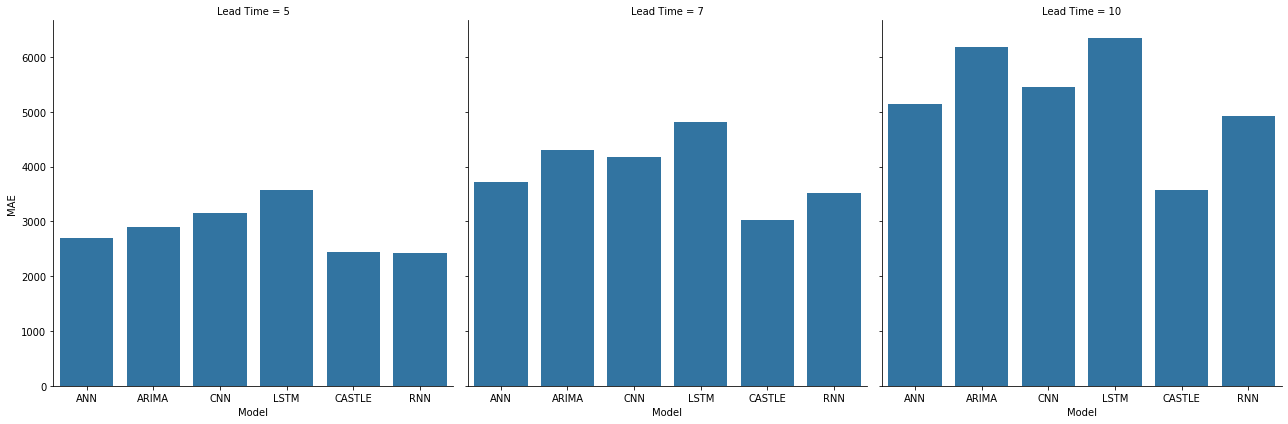

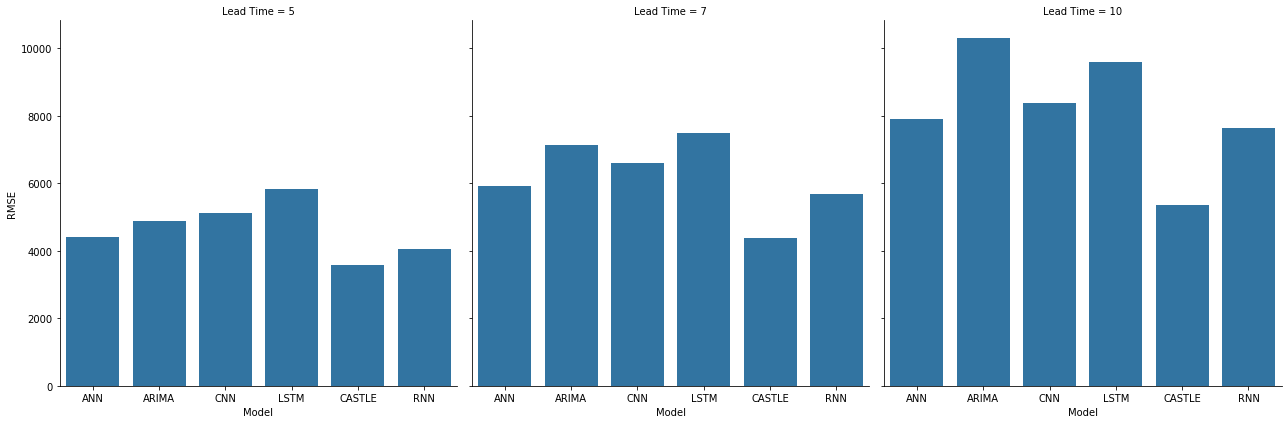

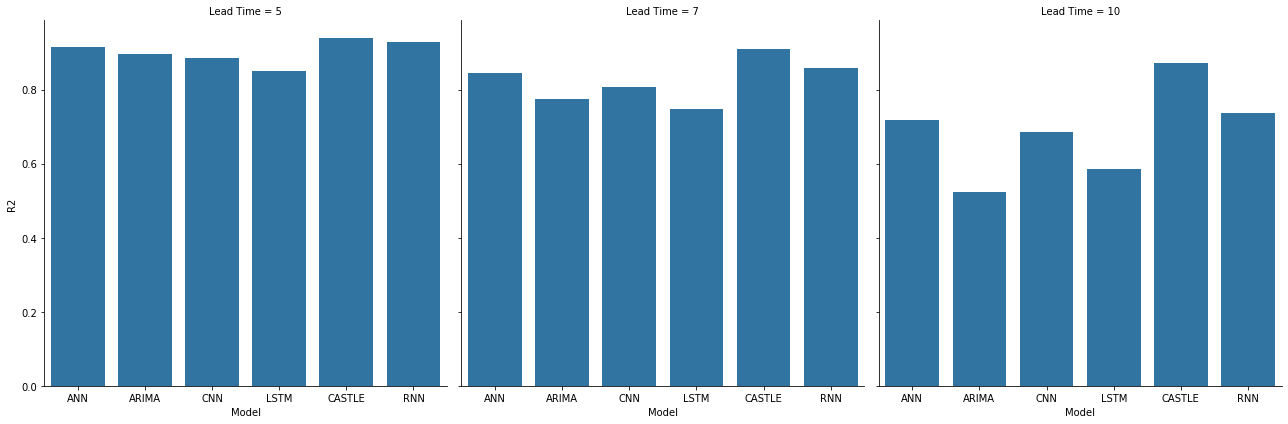

In [6]:
height = 6
g = sns.FacetGrid(df_result, col="Lead Time",margin_titles=True, height=height)
g.map(sns.barplot,  "Model", "MAE")
g = sns.FacetGrid(df_result, col="Lead Time",margin_titles=True, height=height)
g.map(sns.barplot,  "Model", "RMSE")
g = sns.FacetGrid(df_result, col="Lead Time",margin_titles=True, height=height)
g.map(sns.barplot,  "Model", "R2")

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:650: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


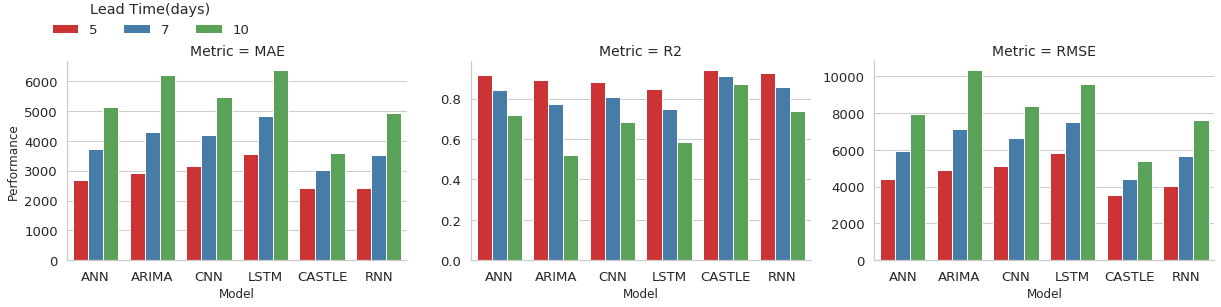

In [60]:
# Set the style and font scale
sns.set(style="whitegrid", font_scale=1.2)

# Set the height
height = 4  # adjust this as needed

# Create the FacetGrid and plot for MAE
g = sns.FacetGrid(melted_df_metrics, col="Metric", margin_titles=True, height=height,aspect=1.5,  sharey=False)
g.map(sns.barplot, "Model", "Value", "Lead Time", palette="Set1")
# Adjust column titles font size
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=14)

# Adjust x and y labels font size
g.set_axis_labels(x_var="Model", y_var="Performance")
for ax in g.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)
g.add_legend(title="Lead Time(days)", bbox_to_anchor=(0.1, 0.9), loc="lower center", ncol=3)
# Show the plot
plt.show()

In [ ]:
# Set the style and font scale
sns.set(style="whitegrid", font_scale=1.2)

# Set the height
height = 4  # adjust this as needed

# Create the FacetGrid and plot for Metrics
g = sns.FacetGrid(melted_df_metrics, col="Metrics", margin_titles=True, height=height, sharey=False)
g.map(sns.barplot, "Model", "Values", hue="Lead Time", palette="Set1")

# Adjust column titles font size
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=14)

# Adjust x and y labels font size
g.set_axis_labels(x_var="Model", y_var="Performance")
for ax in g.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)

# Show the plot
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'bar'

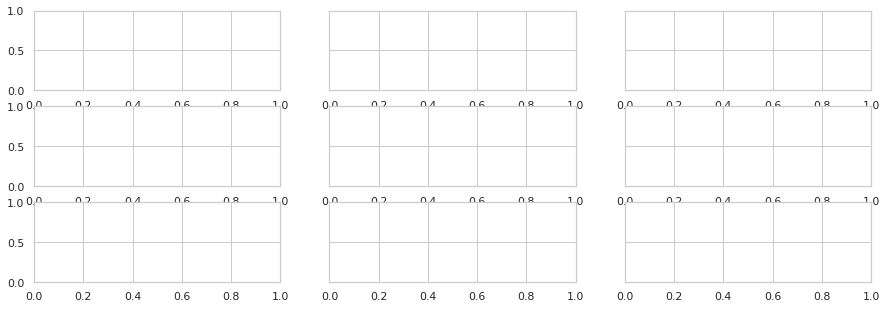

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns


# Set the style
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Get unique lead times
unique_lead_times = df_result["Lead Time"].unique()

# Create the plot
fig, axes = plt.subplots(3, len(unique_lead_times), figsize=(15, 5), sharey=True)

for i, lead_time in enumerate(unique_lead_times):
    data_subset = df_result[df_result["Lead Time"] == lead_time]
    
    ax = axes[i]
    sns.barplot(data=data_subset, x="Model", y="MAE", ax=ax, label="MAE")
    sns.barplot(data=data_subset, x="Model", y="RMSE", ax=ax, label="RMSE")
    sns.barplot(data=data_subset, x="Model", y="R2", ax=ax, label="R2")
    
    ax.set_title(f"Lead Time: {lead_time}", fontsize=14)
    ax.set_xlabel("Model", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    ax.set_xticklabels(data_subset["Model"], rotation=45, ha="right")
    ax.legend(title="Metric", loc="upper left", fontsize=10)

plt.tight_layout()
plt.show()
